# Solving large linear ODEs with matrix-free operators by Krylov methods

Presented by Chiyoung Ahn (chiyahn@mail.ubc.ca)

This notebook demonstrates how Julia `DiffEq` ecosystem can be used to solve large systems of linear ODEs rapidly.

In [ ]:
# package installation -- no need to run if they are installed already
] add BenchmarkTools Parameters DifferentialEquations IterativeSolvers LinearMaps DiffEqOperators

In [1]:
using LinearAlgebra, SparseArrays, Parameters, DifferentialEquations, IterativeSolvers, LinearMaps, DiffEqOperators
using Plots, BenchmarkTools

## Solving linear ODEs with old school matrix-based operators

Consider a continuous-time Markov chain model on a $N$-dimensional path with large $N$ and the following transition matrix:
$$
Q = 
\begin{pmatrix}
-\theta & \theta & 0 & ... & ...  & ...  & 0 \\
\theta/2 & -\theta & \theta/2 & 0  & \ddots & ...& 0 \\
0 & \theta/2 & -\theta & \theta/2 & 0  & \ddots  & \vdots \\
0 & 0 & \theta/2 & -\theta & \theta/2 & 0 & \vdots \\
\vdots & \ddots & \ddots & \ddots & \ddots  &\ddots  & \vdots \\
0 & ... & ... & ... & 0 & \theta & -\theta
\end{pmatrix}
$$
For instance, for $\theta = 0.5$ with $N = 4$, the chain is
$$
\begin{pmatrix}
-0.5 & 0.5 & 0 & 0 \\
0.25 & -0.5 & 0.25 & 0 \\
0 & 0.25 & -0.5 & 0.25 \\
0 & 0 & 0.5 & -0.5
\end{pmatrix}
$$

For now we assume that $Q$ is time-independent; later in this tutorial we will consider time-variant Markov chain with discrete time steps. The path $f(t)$ associated with $Q$ at $t$ is determined by
$$
f'(t) = Q^T f(t)
$$

Creating a matrix for this particular model is relatively easy:

In [2]:
function get_Q_T_matrix(N) 
    # construct a base matrix
    mat = spdiagm(-1 => fill(θ/2, N-1), 0 => fill(-θ, N), 1 => fill(θ/2, N-1))
    # (1,2) and (N,N-1) elements should be 0.5
    mat[1,2] = θ
    mat[N,(N-1)] = θ
    return mat
end

# define transition matrix Q
N = 4
θ = 0.5
Q_T = get_Q_T_matrix(N)
display(Matrix(Q_T')) # display Q

4×4 Array{Float64,2}:
 -0.5    0.5    0.0    0.0 
  0.25  -0.5    0.25   0.0 
  0.0    0.25  -0.5    0.25
  0.0    0.0    0.5   -0.5 

so is solving the system:

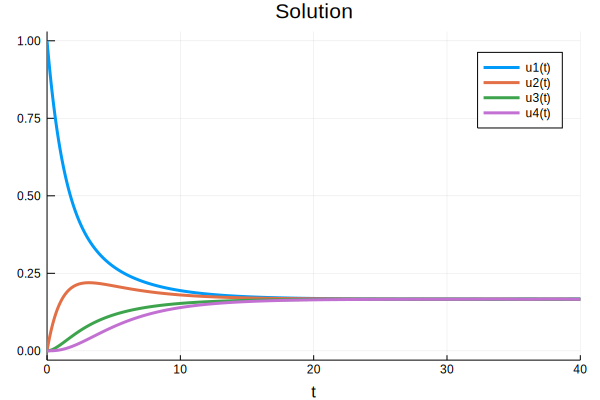

In [3]:
# solve model with matrix Q
function solve_transition_dynamics_matrix(Q_T_matrix, f_0, T)
    # define the corresponding ODE problem
    df(f,p,t) = Q_T_matrix * f
    prob = ODEProblem(df,f_0,(0.0,T))
    # solve using a default solver
    solve(prob)
end
f_0 = [1.0; fill(0.0, N-1)]
sol = solve_transition_dynamics_matrix(Q_T, f_0, 40.0)
plot(sol, title="Solution")

Even if we have used sparse matrices, once $N$ gets fairly large, retrieving the solution can take a huge amount of time. Consider the following case with $N = 10^6$:

In [4]:
N = 10^6
Q = get_Q_T_matrix(N)
f_0 = [1.0; fill(0.0, N-1)]
@btime solve_transition_dynamics_matrix(Q, f_0, 40.0);

  7.956 s (2927 allocations: 9.22 GiB)


Certainly doable, but once we have something like $N = 10^8$, computation becomes simply impossible. Also, when we have a complex transition process, writing a transition process in a matrix form can be fairly difficult or undesirable!

## Rapidly solving linear ODEs with matrix-free operators by Krylovin'

Here we show how matrix free operators for $Q^T$ can be defined without relying on a matrix. First, define a function `Q_transpose!` that determines the multiplicative behaviour:

In [5]:
function Q_T!(df, f, p, t)
    @unpack θ, N = p
    df[1] = -θ*f[1]+θ/2*f[2]
    df[N] = θ/2*f[N-1]-θ*f[N]
    for i in 2:(N-1)
        df[i] = θ/2*f[i-1] - θ*f[i] + θ/2*f[i+1]
    end
    df[2] += θ/2*f[1] # from i = 1
    df[N-1] += θ/2*f[N] # from i = N
end

Q_T! (generic function with 1 method)

which is essentially allocating $Q^T f(t)$ into `df` ($f'(t)$). We can then define the corresponding matrix-free operator `O!`; note that some additional properties have to be assigned as well:

In [6]:
N = 4
p = (θ = θ, N = N)
O! = MatrixFreeOperator(Q_T!, (p, 0.0))
Base.size(::typeof(O!), n) = n==1 || n == 2 ? N : 1
LinearAlgebra.opnorm(::typeof(O!), n::Real) = n==Inf ? 0.1 : nothing
LinearAlgebra.ishermitian(::typeof(O!)) = false

Solving the ODE problem with matrix-free operators is fairly similar to the one for matrix based linear ODEs. Once we use Krylov methods, the solution can be readily found in a few seconds.

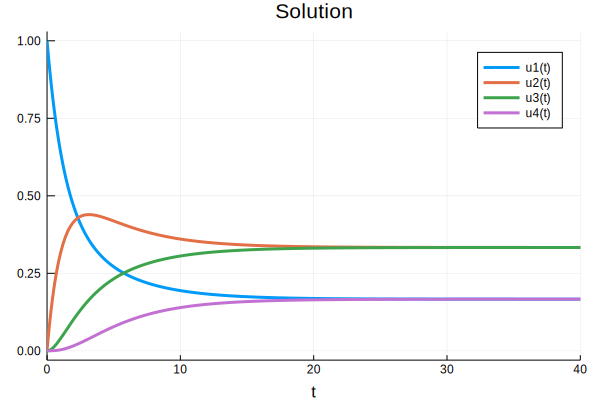

In [7]:
# solve model without matrix
function solve_transition_dynamics(O!, f_0, T, p; dt=1.0)
    # define the corresponding ODE problem
    prob = ODEProblem(O!,f_0,(0.0,T), p)
    # solve using Krylov methods
    solve(prob, LinearExponential(krylov=:simple), tstops=union(0:dt:T, T)) 
end
N = 4
f_0 = [1.0; fill(0.0, N-1)]
sol = solve_transition_dynamics(O!, f_0, 40.0, p)
plot(sol, title="Solution")

Compare the performance and memory allocation for $N = 10^6$ case:

In [8]:
N = 10^6

# define matrix-free operators
p = (θ = θ, N = N)
O! = MatrixFreeOperator(Q_T!, (p, 0.0))
Base.size(::typeof(O!), n) = n==1 || n == 2 ? N : 1
LinearAlgebra.opnorm(::typeof(O!), n::Real) = n==Inf ? 0.1 : nothing
LinearAlgebra.ishermitian(::typeof(O!)) = false

# solve!
f_0 = [1.0; fill(0.0, N-1)]
params = (θ = θ, N = N)
@btime solve_transition_dynamics(O!, f_0, 40.0, params);

  5.567 s (7716 allocations: 1.04 GiB)


Magnificent!

## Computing stationary distributions

It is well-known that stationary distributions of Markov chains can be computed by finding the normalized eigenvector of the transpose of the transition matrix $Q^T$ associated with the eigenvalue of zero, i.e., finding $v$ such that $Q^T v = 0$. For large systems with complex dynamics, computing the solution can be fairly difficult. 

In Julia, `IterativeSolvers` can be used to find the solution using iterative methods such as conjugate gradient and GMRES. Good news is that, `IterativeSolvers` also supports matrix-free operators too:

In [9]:
N = 10^3

# define parameters for matrix-free operator basis (Q_transpose!)
p = (θ = θ, N = N)

# find the stationary distribution (`stationary`)
map_matfree! = LinearMap((y,x) -> Q_T!(y, x, p, 0.0), N; ismutating=true) # defines multiplicative behaviour
stationary, history = @btime gmres!(fill(1/N, N), map_matfree!, fill(0.0, N), log = true)
stationary /= sum(stationary) # normalize
stationary

  11.965 ms (24056 allocations: 1.17 MiB)


1000-element Array{Float64,1}:
 0.0005013318738344457
 0.0010026636938252603
 0.0010026635333832037
 0.0010026632587072945
 0.001002662867682826 
 0.0010026623616061884
 0.0010026617403208376
 0.0010026610006191707
 0.0010026601423570138
 0.001002659165388317 
 0.0010026580686408489
 0.0010026568498214903
 0.001002655508322073 
 ⋮                    
 0.001002656849826858 
 0.0010026580686382856
 0.0010026591653891875
 0.0010026601423616982
 0.001002661000616015 
 0.0010026617403234468
 0.0010026623616085175
 0.001002662867678423 
 0.0010026632587105998
 0.0010026635333819055
 0.001002663693820903 
 0.0005013318738363204